### Dataset preview

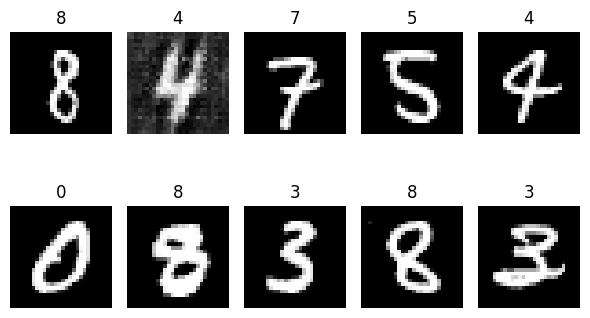

In [1]:
import os
os.chdir("..")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" 
import matplotlib
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from PIL import Image
import torch
import random

# --- Load dataset ---
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder("./data/train", transform=transform)

# --- Visualize some samples ---
%matplotlib inline

fig, axes = plt.subplots(2, 5, figsize=(6, 4))

for ax in axes.flat:
    i = random.randint(0, len(dataset) - 1)
    img, label = dataset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(dataset.classes[label])
    ax.axis("off")

plt.tight_layout()
plt.show()

### Label distribution

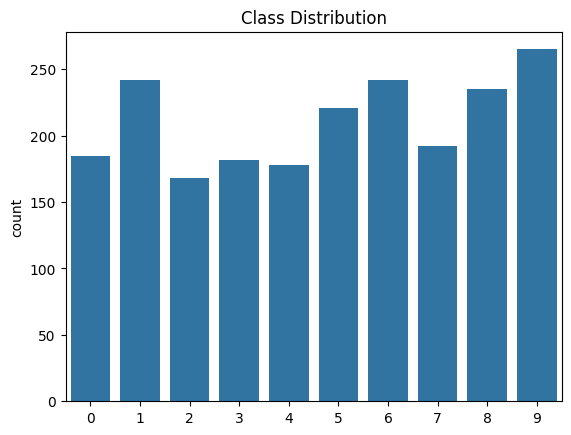

In [2]:
import seaborn as sns

labels = [label for _, label in dataset.samples]
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.show()

### Evaluate the saved model on test data

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# --- Dataset parameters ---
batch_size = 16
img_size = (28, 28)
test_dir = "./data/test"   # or "./data/Test" depending on your folder name

# --- Transform ---
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# --- Test dataset & loader ---
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- Class names ---
class_names = test_dataset.classes
print("Classes:", class_names)
print("Number of test samples:", len(test_dataset))


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Number of test samples: 1000


In [4]:
from src.models.cnn_model import CNNModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(num_classes=len(class_names))
model.load_state_dict(torch.load("./checkpoints/best_model.pth", map_location=device))
model.to(device)
model.eval()

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=576, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)

Model Evaluation Summary
-------------------------
Accuracy : 0.9600
Precision: 0.9607
Recall   : 0.9600
F1-Score : 0.9598



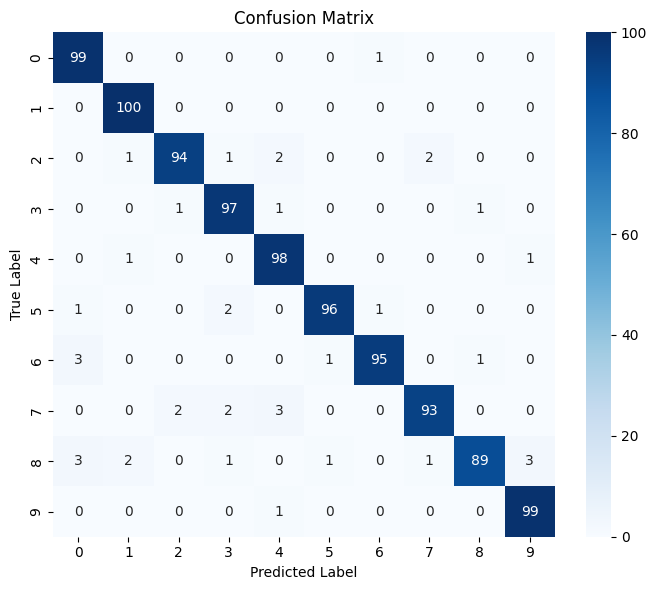

In [5]:
# --- Evaluation Metrics (Clean Version) ---
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# --- Collect predictions and true labels ---
all_preds, all_labels = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# --- Compute overall metrics ---
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("Model Evaluation Summary")
print("-------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}\n")


# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [6]:
from torchinfo import summary
from src.models.cnn_model import CNNModel

model = CNNModel(num_classes=10)
summary(model, input_size=(1, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─MaxPool2d: 1-2                         [1, 16, 14, 14]           --
├─Dropout: 1-3                           [1, 16, 14, 14]           --
├─Conv2d: 1-4                            [1, 32, 14, 14]           4,640
├─MaxPool2d: 1-5                         [1, 32, 7, 7]             --
├─Dropout: 1-6                           [1, 32, 7, 7]             --
├─Conv2d: 1-7                            [1, 64, 7, 7]             18,496
├─MaxPool2d: 1-8                         [1, 64, 3, 3]             --
├─Dropout: 1-9                           [1, 64, 3, 3]             --
├─Linear: 1-10                           [1, 20]                   11,540
├─Linear: 1-11                           [1, 10]                   210
Total params: 35,046
Trainable params: 35,046
Non-trainable params: 0
To

### GRAD-CAM for 10 samples

Found 10 misclassified samples.


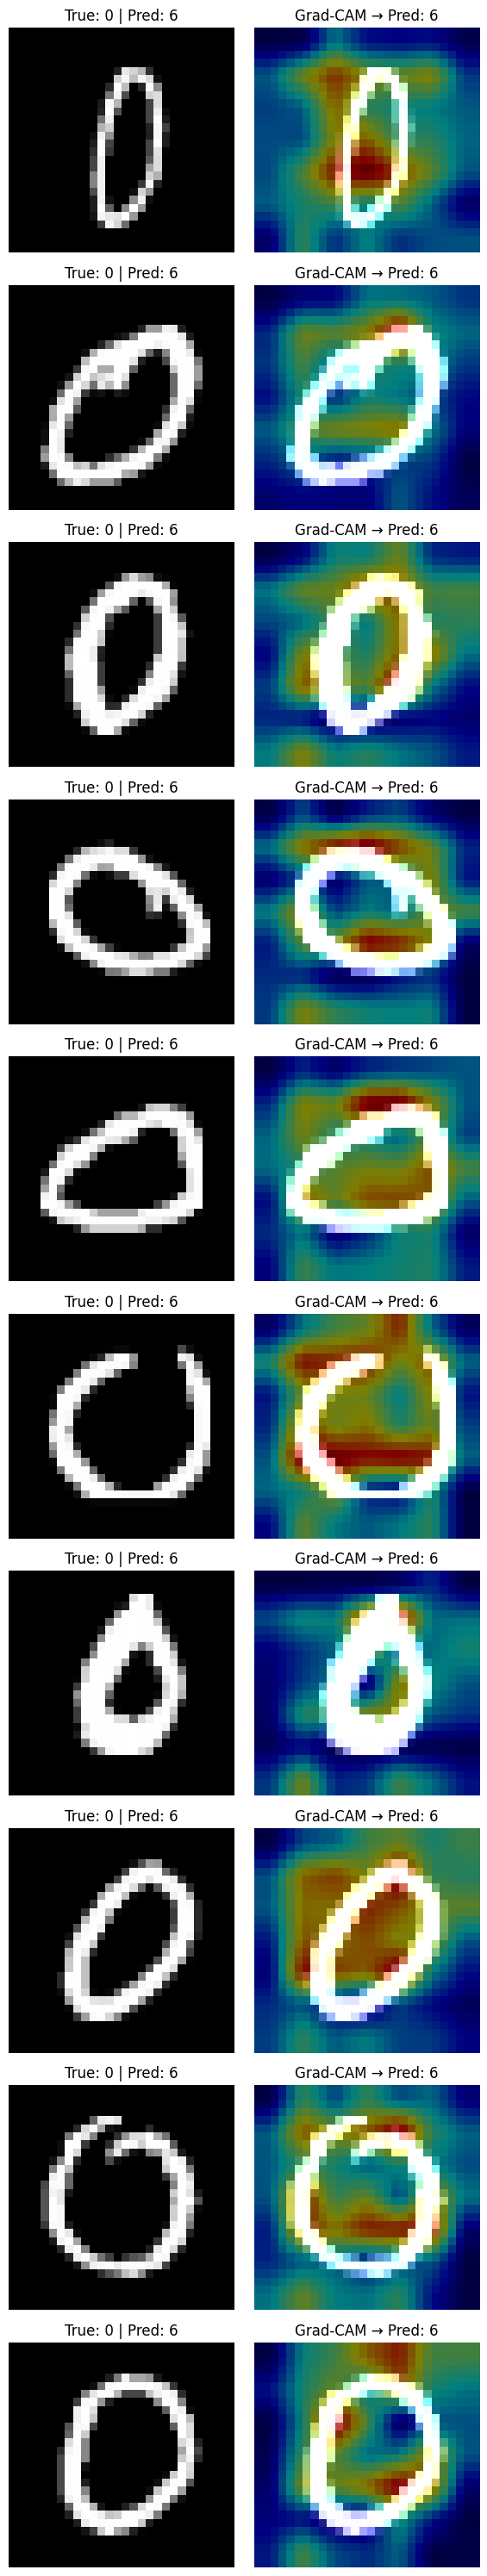

In [7]:
from src.utils.explain import show_misclassified_gradcams

show_misclassified_gradcams(
    model=model,
    dataloader=test_loader,
    device=device,
    class_names=class_names,
    max_samples=10,
    layer_name="conv3"
)


In [8]:
from torchview import draw_graph
from src.models.cnn_model import CNNModel

model = CNNModel(num_classes=10)
graph = draw_graph(model, input_size=(1, 1, 28, 28))
graph.visual_graph.render("cnn_architecture", format="png")



(process:23160): Pango-WARNING **: 18:20:07.026: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


'cnn_architecture.png'